A convolution is defined as:  

  \begin{equation}                                                                           
    (f \star g)(t) \equiv \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau                   
  \end{equation}                                                                             

  It is easy to compute this with FFTs, via the _convolution theorem_,   
                                                                      
  \begin{equation}                                         
    \mathcal{F}\{f \star g\} = \mathcal{F}\{f\} \, \mathcal{F}\{g\}                                          
  \end{equation}                                         
  That is: the Fourier transform of the convolution of $f$ and $g$ is simply
  the product of the individual transforms of $f$ and $g$.  This allows us
  to compute the convolution via multiplication in Fourier space and then take
  the inverse transform, $\mathcal{F}^{-1}\{\}$, to recover the convolution in real space:
  
  \begin{equation}
  f \star g = \mathcal{F}^{-1}\{ \mathcal{F}\{f\} \, \mathcal{F}\{g\}\}
  \end{equation}
  
A common use of a convolution is to smooth noisy data, for example by convolving noisy data with a Gaussian.  We'll do that here.


In [1]:
import numpy as np
def fdata(x, L):
    A = L/10.0
    return 2*np.sin(2*np.pi*x/L) + x*(L-x)**2/L**3 * np.cos(x) + \
           5*x*(L-x)/L**2 + A/2 + 0.1*A*np.sin(13*np.pi*x/L)

N = 2048
L = 50.0
x = np.linspace(0, L, N, endpoint=False)
orig = fdata(x, L)
noisy = orig + 0.5*np.random.randn(N)

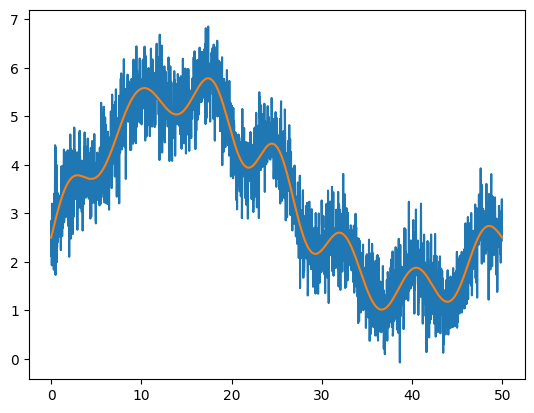

In [2]:
from matplotlib import pyplot as plt
plt.plot(x, noisy)
plt.plot(x, orig)

SciPy provides a convolution function `scipy.signal.convolve()` that can do the convolution for us directly.  To smooth the data, we want to use a Gaussian, which can be produced by `scipy.signal.gaussian()`.

Convolve the noisy data with a Gaussian and plot the result together with the original data `orig`.  You'll need to play with the width of the Gaussian to get a nice smoothing.  You also will need to normalize the Gaussian so that it sums to 1, otherwise, your convolved data will be shifted verfically from the original function.

/var/folders/3b/qn0pc7tj0t55f41t81nwsjvm0000gn/T/ipykernel_97289/3051839980.py:4: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  g = signal.gaussian(len(x), sigma, False)/np.sqrt(2*np.pi*sigma**2)


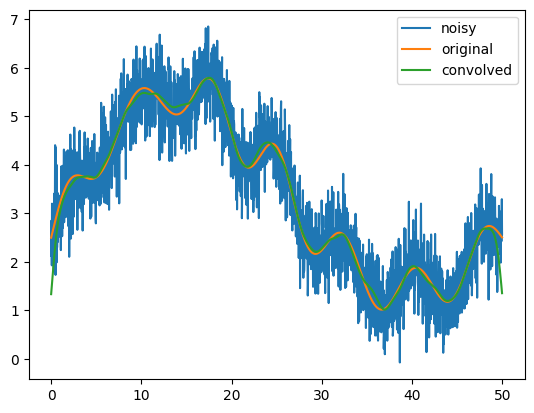

In [4]:
from scipy import signal

sigma = 20
g = signal.gaussian(len(x), sigma, False)/np.sqrt(2*np.pi*sigma**2)
conv = signal.convolve(noisy, g, mode='same')


plt.plot(x, noisy)
plt.plot(x, orig)
plt.plot(x, conv)

plt.legend(['noisy', 'original', 'convolved'])

Ok, this works but I want to find the optimal value of sigma.
I do a simple chi-2 optimization.

Notice that there will be distortions proportional to the sigma at the boundaries. I simply skip the boundaries.

Best sigma: 20.289855210732842


/var/folders/3b/qn0pc7tj0t55f41t81nwsjvm0000gn/T/ipykernel_9072/4170894105.py:7: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  g = signal.gaussian(len(x), sigma, False)/np.sqrt(2*np.pi*sigma**2)
/var/folders/3b/qn0pc7tj0t55f41t81nwsjvm0000gn/T/ipykernel_9072/4170894105.py:20: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  g = signal.gaussian(len(x), sigma, False)/np.sqrt(2*np.pi*sigma**2)


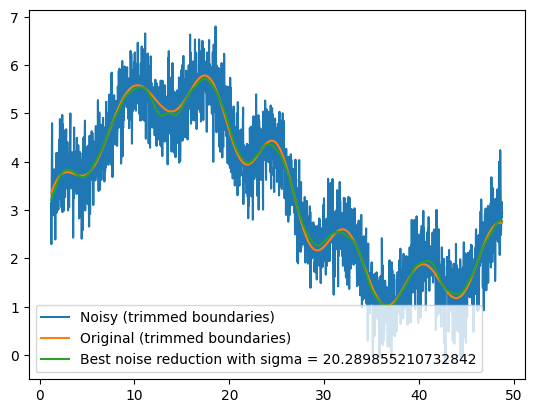

In [57]:
from scipy.optimize import minimize


def chi2(observed, model):
    return np.sum((observed - model)**2/model)
def cost(sigma):
    g = signal.gaussian(len(x), sigma, False)/np.sqrt(2*np.pi*sigma**2)
    conv = signal.convolve(noisy, g, mode='same')
    trimmed_conv = conv[50:-50]
    trimmed_orig = orig[50:-50]
    #plt.plot(x, conv)
    return chi2(trimmed_conv, trimmed_orig)

res = minimize(cost, 20, bounds=[(1, 30)])
#print(res)
sigma = res.x[0]
print(f"Best sigma: {sigma}")  


g = signal.gaussian(len(x), sigma, False)/np.sqrt(2*np.pi*sigma**2)
conv = signal.convolve(noisy, g, mode='same')

trimmed_conv = conv[50:-50]
trimmed_orig = orig[50:-50]
trimmed_noisy = noisy[50:-50]
trimmed_x = x[50:-50]

plt.plot(trimmed_x, trimmed_noisy)
plt.plot(trimmed_x, trimmed_orig)
plt.plot(trimmed_x, trimmed_conv)
#add legend
plt.legend(['Noisy (trimmed boundaries)', 'Original (trimmed boundaries)', f'Best noise reduction with sigma = {sigma}'], loc = 'best')

## Q2: Interpolation error

There are a large number of different interpolation schemes available through scipy.  Let's test them out.

Create a python function, $f(x)$, that is your true function (make it complicated!).  Now create $N$ samples of it (either regularly spaced or irregularly spaced).

Try some of the different interpolation routines.  `interpolate.interp1d` takes a `kind` argument that let's you choose the order of the interpolation.  Measure the error in the method, by comparing the interpolated result with the actual function value.  

Then do the same cubic splines (look at `CubicSpline`)

Plot the resulting interpolant.

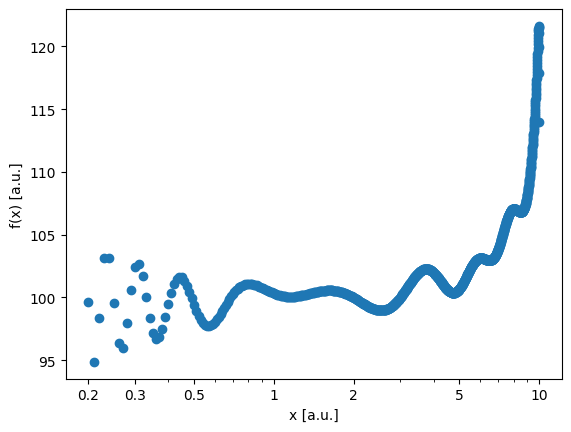

In [139]:
import numpy as np

def f(x):
    return np.sin(2*np.pi/x)/x+np.sin(2*x+2*np.pi)/2+3*np.sin(3*x+3*np.pi)/3 + 0.009*x**np.pi + 1e-9*x**x - 1e-99*x**x**2 + 100

min = 0.2
max = 10
sampfreq = 100
n_samples = int((max-min)*sampfreq)
samples = np.linspace(min, max, int(n_samples))

plt.plot(samples, f(samples), 'o' )
plt.xscale('log')

plt.xlabel('x [a.u.]')
plt.ylabel('f(x) [a.u.]')

plt.xticks(ticks=[0.2, 0.3, 0.5, 1, 2, 5, 10], labels=['0.2', '0.3', '0.5', '1', '2', '5', '10'])
plt.show()



This is an example of a function that it is difficult to interpolate using a uniform grid.

$$f(x) = \frac{\sin\left(\frac{2\pi}{x}\right)}{x} + \frac{\sin(2x + 2\pi)}{2} + 3\frac{\sin(3x + 3\pi)}{3} + 0.009 x^{\pi} + 10^{-9} x^x - 10^{-99} x^{x^2} + 100, \quad \text{for} \quad x \in [0.2, 10]$$

It has fast oscillations at low x values (near 0.2, which is the low edge of the domain) and slow oscillations around higher x values (near 10, the upper edge of its domain).

In order to sample the function correctly, I use a uniform grid with a lot of points. In particular, the highest frequency in this domain is around 50 Hz therefore I can use 100 Hz as uniform sampling frequency for the nyquist theorem. 

For the plotting of interpolation I use a much higher number of points, in particular I use number of points corresponding to a frequency of 1 kHz.

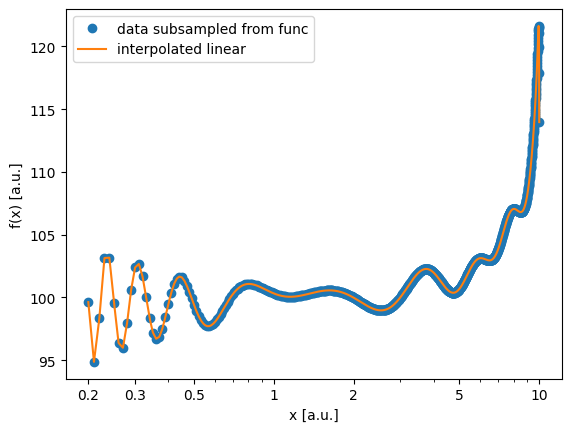

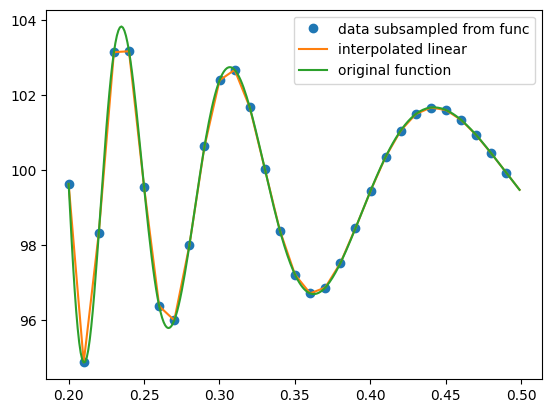

In [149]:
from scipy.interpolate import interp1d

n_samples = int((max-min)*1000)
samples_int = np.linspace(min, max, int(n_samples))

interpolated_func = interp1d(samples, f(samples), kind='linear')

plt.plot(samples, f(samples), 'o', label='data subsampled from func')
plt.plot(samples_int, interpolated_func(samples_int), label='interpolated linear')
plt.xscale('log')

plt.xlabel('x [a.u.]')
plt.ylabel('f(x) [a.u.]')

plt.xticks(ticks=[0.2, 0.3, 0.5, 1, 2, 5, 10], labels=['0.2', '0.3', '0.5', '1', '2', '5', '10'])
plt.legend()
plt.show()


#Zoom from 0.2 to 0.5
samples_trimmed = samples[samples <= 0.5]
samples_int_trimmed = samples_int[samples_int <= 0.5]
plt.plot(samples_trimmed, f(samples_trimmed), 'o', label='data subsampled from func')
plt.plot(samples_int_trimmed, interpolated_func(samples_int_trimmed), label='interpolated linear')
#To compare I plot also the original function with the same sapling frequency as the interpolation
plt.plot(samples_int_trimmed, f(samples_int_trimmed), label='original function')
plt.legend()
plt.show()






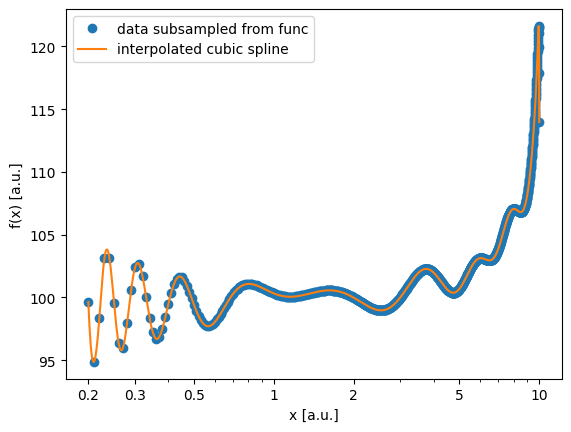

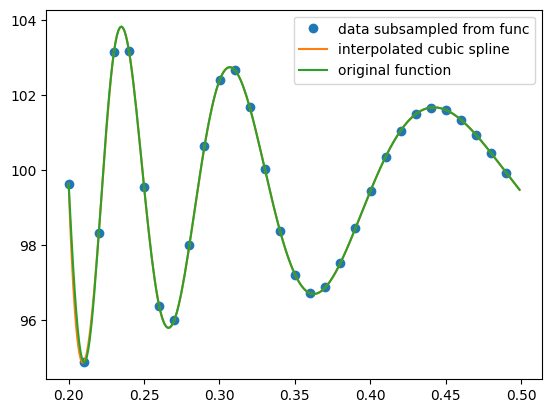

In [150]:
from scipy.interpolate import CubicSpline

cs = CubicSpline(samples, f(samples))

interpolated_values = cs(samples_int)

#Plot the interpolated values against the original function
plt.plot(samples, f(samples), 'o', label='data subsampled from func')
plt.plot(samples_int, interpolated_values, label='interpolated cubic spline')
plt.xscale('log')

plt.xlabel('x [a.u.]')
plt.ylabel('f(x) [a.u.]')

plt.xticks(ticks=[0.2, 0.3, 0.5, 1, 2, 5, 10], labels=['0.2', '0.3', '0.5', '1', '2', '5', '10'])
plt.legend()

plt.show()


#Zoom from 0.2 to 0.5
samples_trimmed = samples[samples <= 0.5]
samples_int_trimmed = samples_int[samples_int <= 0.5]
plt.plot(samples_trimmed, f(samples_trimmed), 'o', label='data subsampled from func')
plt.plot(samples_int_trimmed, interpolated_values[samples_int <= 0.5], label='interpolated cubic spline')
#To compare I plot also the original function with the same sapling frequency as the interpolation
plt.plot(samples_int_trimmed, f(samples_int_trimmed), label='original function')
plt.legend()

plt.show()


Conclusion:
It is clear that a cubic interpolation is much more similar to the original function.

At lower frequencies (near to the upper edge of the domain for x near 10) both interpolations work pretty well.